In [368]:
# Add Necessary Imports
import re
import bs4
import time
import html
import json
import nltk
import string
import requests
import dateparser
import numpy as np
import pandas as pd
import seaborn as sns
from uuid import uuid4
from sklearn import svm
from  bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from typing import List, Dict, Optional
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from wordcloud import  WordCloud,  ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Set the Plot style to use Seaborn's style
plt.style.use(style="seaborn")
%matplotlib inline

## Helper functions for Scraping

In [154]:
def get_hotels_from_pages(url: str, start: int = 1, stop: int = 1) -> Dict:

    """
    This function gets the Hotel names, URLs and review Url of hotel from a page

    Args
        start: the starting page number
        stop: the last page number
        page_url: the Url of the page where hotels 

    Returns:
        Dict: A Dictionary containing the Hotel names, Hotel URL, and Hotel Reviews page
    """
    pages_on_hotel = None

    hotel_dict = {}
    hotel_url = None
    hotel_name = None
    
    for index in range(start, stop + 1, 1):
        page_url = f"{url}/{index}"
        hotels_response = requests.get(page_url)
        try:
            if hotels_response.status_code == 200:
                soup = BeautifulSoup(hotels_response.content)

                hotel_divs = soup.find_all(class_="listing-hotels-details-property")

                for hotel_div in hotel_divs:
                    hotel_url = hotel_div.a['href']
                    hotel_name = hotel_div.h2.text
                    hotel_review_url = f'{hotel_url}/reviews'

                    hotel_dict[str(uuid4())] = {'url': hotel_url, 'hotel_name': hotel_name, 'review_url' : hotel_review_url}

        except Exception as e:
            print(e)  

    return hotel_dict

def get_ratings(ratings_tag: bs4.element.Tag) -> List:
    """
    This function gets the ratings value and category from a hotel reviews page

    Args
        ratings_tag: the ratings tag 

    Returns:
        List: A List containing the ratings_value and ratings category
    """

    ratings_value = None
    ratings_category = None
    ratings_text = ratings_tag.text
    ratings_value_match = re.search(r'(\d{1,2}\.\d)', ratings_text)
    ratings_category_match = re.search(r'([a-z\s]+)', ratings_text, re.IGNORECASE)

    if ratings_value_match:
        ratings_value = ratings_value_match.group(1)
    if ratings_category_match:
        ratings_category = ratings_category_match.group(1)
        
    return ratings_value, ratings_category


def get_reviews_from_hotel(hotels_dict: Dict) -> List[pd.DataFrame]:
    """
    This function gets the Reviews from a hotel reviews page

    Args
        hotels_dict: the Dictionary that contains the Hotels information 

    Returns:
        List: A List containing the Hotels and metadata
    """
    reviews_list = None
    ratings_list = None
    person_reviews_list = None

    cleaned_review_list = []
    cleaned_person_reviews_list = []
    cleaned_ratings_value_list = []
    cleaned_ratings_string_list = []
    hotel_name_list = []


    df = None
    df_list = []

    for index, review_details in hotels_dict.items():
        response = requests.get(review_details['review_url'])
        try:
            if response.status_code == 200:
                reviews_soup = BeautifulSoup(response.content)
                reviews_list = reviews_soup.select("article > p[class='']")
                ratings_list = reviews_soup.find_all(class_='sph-reviews-individual-rating')
                ratings_list = [get_ratings(rating_pair) for rating_pair in ratings_list]
                person_reviews_list = reviews_soup.select("article > p[class=sph-reviews-person]")

            if reviews_list and person_reviews_list and ratings_list:
                for review, person, rating in zip(reviews_list, person_reviews_list, ratings_list):
                    cleaned_review_list.append(review.text)
                    cleaned_person_reviews_list.append(person.text)
                    cleaned_ratings_value_list.append(rating[0])
                    cleaned_ratings_string_list.append(rating[1])
                    hotel_name_list.append(review_details['hotel_name'])


        except Exception as e:
            print(e)
            
    df = pd.DataFrame({"reviews": cleaned_review_list, "person_reviews_list": cleaned_person_reviews_list, 
                       "ratings_category": cleaned_ratings_string_list, "ratings_score":cleaned_ratings_value_list})
    df['id'] = index
    df[['name', 'created_at']] = df['person_reviews_list'].str.split("\son\s", expand=True)        
    df['name'] = df.name.str.replace('by\s', '')
    df['created_at'] = df['created_at'].apply(dateparser.parse)
    df['ratings_score'] = df['ratings_score'].astype(float)
    df['hotel_name'] = hotel_name_list


    return df

# Scrape Hotel pages

In [ ]:
# Lagos hotels URL
lagos_hotels = "https://hotels.ng/hotels-in-lagos"

# Scrape the first 50 pages
hotels = get_hotels_from_pages(lagos_hotels, 1, 150)
df = get_reviews_from_hotel(hotels)

# Save as CSV file to use later
# df.to_csv('hotels_ng_scrape.csv', index = False)

In [ ]:
# Save the Hotel list as a DataFrame
hotels_df = pd.DataFrame(hotels).T
hotels_df.reset_index(inplace=True)

# Save as CSV file to use later
# hotels_df.to_csv("hotel_list.csv", index=False)

# Read in Scraped CSV files

In [388]:
# Read the Hotels CSV into DataFrame
df = pd.read_csv('hotels_ng_scrape.csv')
hotels_df = pd.read_csv('hotel_list.csv', dtype={'ratings_category': "string",
                                                 'reviews':"string",
                                                 'ratings_score':float})

# EDA (Exploratory Data Analysis)

First of all, let us get a general overview of the Dataset

In [254]:
df.head(10)

,reviews,person_reviews_list,ratings_category,ratings_score,id,name,created_at,hotel_name
0,"Enjoyable stay, I felt okay and the staff were...","by Amaka on March 27, 2020",Excellent,9.2,e41eb59d-74a2-4299-9ae0-7d2bd22398d0,Amaka,2020-03-27,Ibis Lagos Airport
1,Everything went well thought out my stay. Comf...,"by Willie on March 22, 2020",Very Good,8.4,e41eb59d-74a2-4299-9ae0-7d2bd22398d0,Willie,2020-03-22,Ibis Lagos Airport
2,Very comfortable environment with excellent se...,"by Adebowale on March 22, 2020",Excellent,10.0,e41eb59d-74a2-4299-9ae0-7d2bd22398d0,Adebowale,2020-03-22,Ibis Lagos Airport
3,Comfortable and conveniently located. The brea...,"by Ademola on March 22, 2020",Excellent,10.0,e41eb59d-74a2-4299-9ae0-7d2bd22398d0,Ademola,2020-03-22,Ibis Lagos Airport
4,"The services was bad, the bed was not good. Ch...","by Charles on March 11, 2020",Very Good,7.2,e41eb59d-74a2-4299-9ae0-7d2bd22398d0,Charles,2020-03-11,Ibis Lagos Airport
5,They need to renew their maintenance.,"by Teresa on February 28, 2020",Very Good,7.6,e41eb59d-74a2-4299-9ae0-7d2bd22398d0,Teresa,2020-02-28,Ibis Lagos Airport
6,"Services was okay, the staff were helpful. How...","by Olatunji on February 26, 2020",Very Good,7.6,e41eb59d-74a2-4299-9ae0-7d2bd22398d0,Olatunji,2020-02-26,Ibis Lagos Airport
7,"Excellent service, I had a nice stay.","by Akamah on February 26, 2020",Excellent,9.2,e41eb59d-74a2-4299-9ae0-7d2bd22398d0,Akamah,2020-02-26,Ibis Lagos Airport
8,The services was okay but the room size was sm...,"by Mary on February 26, 2020",Excellent,8.8,e41eb59d-74a2-4299-9ae0-7d2bd22398d0,Mary,2020-02-26,Ibis Lagos Airport
9,My stay was fantastic,"by Oluwatoyin on February 3, 2020",Excellent,8.8,e41eb59d-74a2-4299-9ae0-7d2bd22398d0,Oluwatoyin,2020-02-03,Ibis Lagos Airport


In [255]:
df.shape

(7437, 8)

Looking at the dataset, we observe that there are **7437** rows and **7** Columns

However, we can observe that we will not be needing **all the columns**, and so we should only select the **necessary columns** relevant for this analysis. Overall, we would like to capture the following:

- Reviews (comments)
- Ratings (category and score)

The columns of interest that do well to capture the following are: **['reviews', 'ratings_category', 'ratings_score']**

In [256]:
# Select only relevant columns
df = df[['reviews', 'ratings_category', 'ratings_score']]

### Handling Missing Values

In [257]:
# Get missing values per column
df.isnull().sum()

reviews             1
ratings_category    0
ratings_score       0
dtype: int64

In [258]:
# Highlight the missing value
df[df.reviews.isnull()]

,reviews,ratings_category,ratings_score
5290,NaN,Very Good,8.4


We observe that there is only one missing value in the entire dataset, and this missing value is in the reviews column. Since there is only one missing value, we can choose to drop this row. 

In [259]:
# Drop missing value
df.dropna(inplace=True)

# Reset the index so it is back to the normal count 
df = df.reset_index(drop=True)

In [260]:
# Get a summarised statistical description of the data
df.describe(include='all')

,reviews,ratings_category,ratings_score
count,7436,7436,7436.000000
unique,7277,4,NaN
top,My stay was okay.,Very Good,NaN
freq,15,2736,NaN
mean,NaN,NaN,7.014591
std,NaN,NaN,2.490294
min,NaN,NaN,0.000000
25%,NaN,NaN,6.000000
50%,NaN,NaN,7.600000
75%,NaN,NaN,8.800000


Now, we can see a summarised statistcal overview of the data. We can observe the following:
- the **maximum ratings score recorded was 10 and the minimum was 0**
- the **mean ratings score is 7.01**
- the reviews and ratings_category are of non-numeric data type
- We now also have a count of 7436 rows since we dropped one null value

With this, we should try to get a more about the total ratings category and the ratings score

In [261]:
# Group the data by the ratings_category and perform a total count of each review under each category
df.groupby('ratings_category').count()['reviews'].sort_values(ascending=True)

ratings_category
Poor          784
Fair         1803
Excellent    2113
Very Good    2736
Name: reviews, dtype: int64

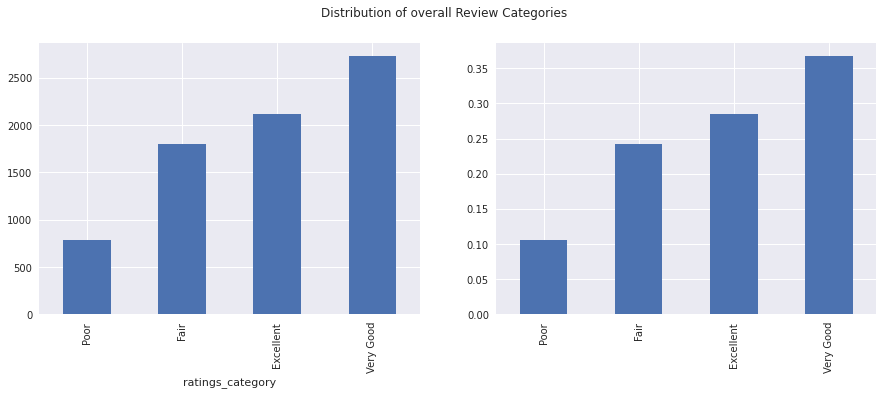

In [262]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))



df.groupby('ratings_category').count()['reviews'].sort_values(ascending=True).plot(kind='bar',
                                                                                   ax = ax1,
                                                                                   subplots=True,
                                                                                   title='Distribution of overall Review Categories');

# 
df.ratings_category.value_counts(normalize=True).sort_values(ascending=True).plot(kind='bar',
                                                                                   ax = ax2,
                                                                                   subplots=True,
                                                                                   title='Distribution of overall Review Categories');
ax1.title.set_text('')
ax2.title.set_text('')

plt.show();


From the above, we can see that a large number of ratings fall under 'Very Good' and 'Excellent' and then followed by 'Fair'. There are however little 'Poor' review categories.

Next. we should get the range for the ratings categories in this dataset

In [263]:
# Get the Minimum, Maximum, Count, and Mean of each ratings category
# And sort the values starting with the least to the highest rating value
df.groupby('ratings_category')['ratings_score'].agg(['min', 'max', 'count']).sort_values('min')

,min,max,count
ratings_category,,,
Poor,0.0,3.8,784
Fair,4.0,6.4,1803
Very Good,6.6,8.4,2736
Excellent,8.5,10.0,2113


From the above, we can observe the following about the Ratings Category:
- **Poor** ranges from **0.0 - 3.8**
- **Fair** ranges from **4.0 - 6.4**
- **Very Good** ranges from **6.6 - 8.4**
- **Excellent** ranges from **8.5 - 10**

### Could there be a relationship between the length of the review comments given by users and the Ratings Category?

Let's explore this

In [210]:
# Get the length of each individual review comment
df['review_text_length'] = df.reviews.str.len()

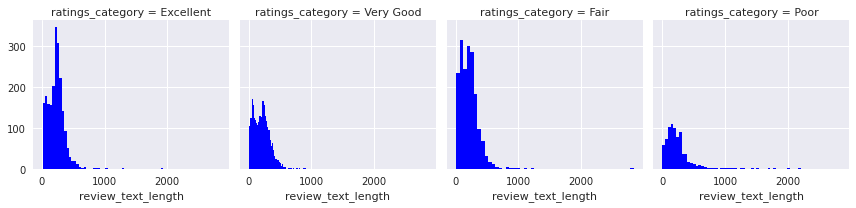

In [211]:
graph = sns.FacetGrid(data=df,col='ratings_category')
graph.map(plt.hist,'review_text_length',bins=50,color='blue');

**Log Scale**

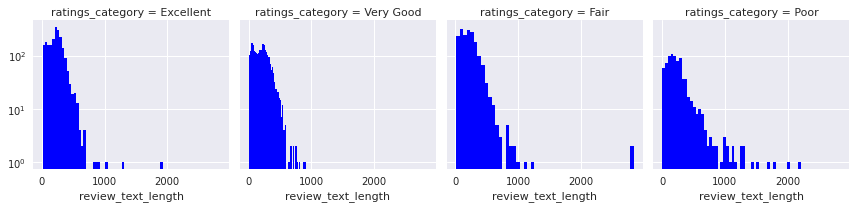

In [212]:
graph = sns.FacetGrid(data=df,col='ratings_category')
graph.map(plt.hist,'review_text_length',bins=50,color='blue').set(yscale = 'log');

Looking at the plots, there does not seem to be any significant relationship  between the review comment text length and the ratings category

### Could there be a relationship between the word count of the review comments given by users and the Ratings Category?

In [269]:
df['review_text_words_count'] = df.reviews.str.split().apply(lambda x: len(x))

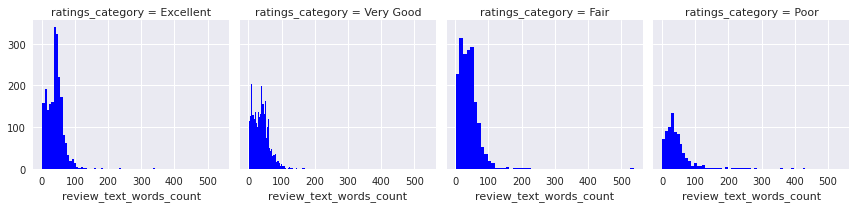

In [271]:
graph = sns.FacetGrid(data=df,col='ratings_category')
graph.map(plt.hist,'review_text_words_count',bins=50,color='blue');

**Log Scale**

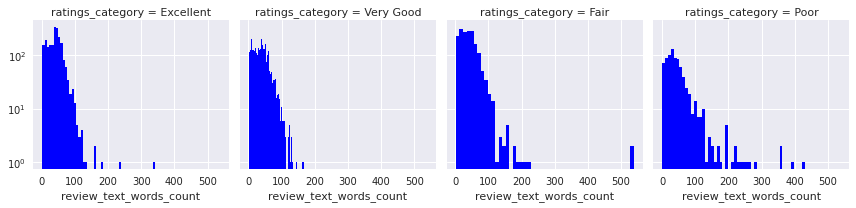

In [272]:
graph = sns.FacetGrid(data=df,col='ratings_category')
graph.map(plt.hist,'review_text_words_count',bins=50,color='blue').set(yscale = 'log');

## Creating a Target Variable

After examining the categories, we observed that **Fair** and **Poor** are of Negative sentiment, while **Very good** and **Excellent** are of Positve sentiment. Hence, we can create a Target variable that captures this logic.

In [273]:
df[df.ratings_category == 'Fair'].sample(10)

,reviews,ratings_category,ratings_score,review_text_words_count
2796,The hotel needs to do a proper maintenance on ...,Fair,5.2,45
5805,"I did not enjoy my stay at the hotel, although...",Fair,5.6,75
3513,Most facilities were not functioning. They roo...,Fair,4.4,14
5907,I did not enjoy my stay. Their services were n...,Fair,6.0,53
6320,"The experience was a shocking one, because the...",Fair,4.8,66
2191,The bathroom was very small that I had to stan...,Fair,5.6,22
1581,"The hotel needs renovation, but I enjoyed my stay",Fair,6.4,9
6905,I had always used this hotel but I think you s...,Fair,6.0,42
2689,The rooms are okay but the service isn't so gr...,Fair,6.0,59
6457,My stay at Admiralty Residency Hotel was not i...,Fair,5.6,64


In [274]:
df[df.ratings_category == 'Poor'].sample(10)

,reviews,ratings_category,ratings_score,review_text_words_count
6921,"The hotel wasn’t up to the standard and also, ...",Poor,2.6,21
4615,"Excellence hotel was a good choice,my stay was...",Poor,0.0,24
6609,My stay was very fine. Hotel environment was c...,Poor,0.0,35
651,I did not enjoy my stay at the hotel. You can ...,Poor,2.0,46
4733,"I had a bad stay at the hotel, the room I chec...",Poor,3.6,49
1781,"Hello, \nI wonder why people are being economi...",Poor,2.0,46
3228,My experience in the hotel was awesome. The se...,Poor,0.0,31
6152,"My experience wasn’t too bad, but I have thing...",Poor,0.0,62
4556,their customer care is excellent. Home away fr...,Poor,0.0,9
4130,"The hotel was dirty, I did not enjoy my stay.",Poor,3.2,10


In [275]:
df[df.ratings_category == 'Very Good'].sample(10)

,reviews,ratings_category,ratings_score,review_text_words_count
7166,"My stay was perfect, it was very short but ex...",Very Good,7.6,34
6957,"I enjoyed every minute I spent at the hotel, t...",Very Good,7.6,58
1227,"My stay at the hotel was nice, the hotel was v...",Very Good,7.6,41
6054,"I really enjoyed my stay at allure Suites, it ...",Very Good,8.4,51
1493,"My stay at the hotel was just fine, the hotel ...",Very Good,7.6,35
556,The staff were always willing to help whenever...,Very Good,8.4,23
5633,"Great place, it was actually easy to locate. T...",Very Good,6.8,76
2394,"It is a nice hotel, totally worth the price.",Very Good,8.0,9
3721,My stay was okay. Thanks to Hotels.ng.,Very Good,8.4,7
2310,I had a great time. I enjoyed all the faciliti...,Very Good,7.2,45


In [276]:
df[df.ratings_category == 'Excellent'].sample(10)

,reviews,ratings_category,ratings_score,review_text_words_count
7396,My stay at the hotel was a pleasurable one. Th...,Excellent,10.0,47
3204,I enjoyed every bit of my stay. The hotel is d...,Excellent,9.2,47
2840,"It was a good experience, the location of the ...",Excellent,9.2,51
320,The environment is safe my stay was fine. I a...,Excellent,9.2,14
5483,"well reputable hotel, with wonderful services,...",Excellent,9.2,55
2064,An outstanding and very pleasant place to stay...,Excellent,10.0,134
216,My stay at the hotel was excellent. The rooms ...,Excellent,10.0,55
2149,"I enjoyed myself, the hotel was very neat and ...",Excellent,10.0,10
2521,beautiful rooms and a FRIENDLY ambience..........,Excellent,10.0,14
171,I had a beautiful and peaceful time at the hot...,Excellent,8.8,34


After performing some manual analysis on the ratings category, I concluded that rating category of **'Fair'** and **'Poor'** falls in the Negative sentiment, while positive sentiment is between **'Very Good'** and **'Excellent'**

In [277]:
# Create a Target variable 
df['target'] = df.ratings_category.apply(lambda x: 0 if x in ['Fair', 'Poor'] else 1)

# Preprocessing

## Text Normalization

### 1. Convert all reviews to Lowercase

In [278]:
# Convert the text in Reviews Column to lowercase
df.reviews = df.reviews.str.lower()

In [279]:
df.head()

,reviews,ratings_category,ratings_score,review_text_words_count,target
0,"enjoyable stay, i felt okay and the staff were...",Excellent,9.2,11,1
1,everything went well thought out my stay. comf...,Very Good,8.4,14,1
2,very comfortable environment with excellent se...,Excellent,10.0,6,1
3,comfortable and conveniently located. the brea...,Excellent,10.0,13,1
4,"the services was bad, the bed was not good. ch...",Very Good,7.2,22,1


### 2. Punctuation and Stopwords removal

We need to remove any words that do not add any meaning to the sentence. Things such as Punctuation and Popular English stopwords, and then spearate the sentences into words (Tokens) for feature extraction.

In [280]:
df.head(10)

,reviews,ratings_category,ratings_score,review_text_words_count,target
0,"enjoyable stay, i felt okay and the staff were...",Excellent,9.2,11,1
1,everything went well thought out my stay. comf...,Very Good,8.4,14,1
2,very comfortable environment with excellent se...,Excellent,10.0,6,1
3,comfortable and conveniently located. the brea...,Excellent,10.0,13,1
4,"the services was bad, the bed was not good. ch...",Very Good,7.2,22,1
5,they need to renew their maintenance.,Very Good,7.6,6,1
6,"services was okay, the staff were helpful. how...",Very Good,7.6,17,1
7,"excellent service, i had a nice stay.",Excellent,9.2,7,1
8,the services was okay but the room size was sm...,Excellent,8.8,16,1
9,my stay was fantastic,Excellent,8.8,4,1


#### Stopwords and Punctuation

In [281]:
def clean_review(tokenized_review: str) -> List:
    """
    This function will remove Punctuatuon, Stopwords in a review

    Args
        tokenized_review: A tokenized review comment 

    Returns:
        List: A List containing the processed Review
    """

    # Remove any Punctuation
    stop_words = stopwords.words('english')
    no_punc = [char for char in tokenized_review if char not in string.punctuation]
    no_punc = ''.join(no_punc)
    
    return [word for word in no_punc.split() if word.lower() not in stopwords.words('english')]


**Before Stopwords and Punctuation removal:**

In [282]:
df.reviews.head()

0    enjoyable stay, i felt okay and the staff were...
1    everything went well thought out my stay. comf...
2    very comfortable environment with excellent se...
3    comfortable and conveniently located. the brea...
4    the services was bad, the bed was not good. ch...
Name: reviews, dtype: object

**After Stopwords and Punctuation removal:**

In [374]:
df['tokens'] = df.reviews.apply(clean_review)
df.tokens.head()

0        [enjoyable, stay, felt, okay, staff, helpful]
1    [everything, went, well, thought, stay, comfor...
2       [comfortable, environment, excellent, service]
3    [comfortable, conveniently, located, breakfast...
4    [services, bad, bed, good, checkingin, stressf...
Name: reviews, dtype: object

**A visualization of some of the most popular words in the Reviews**

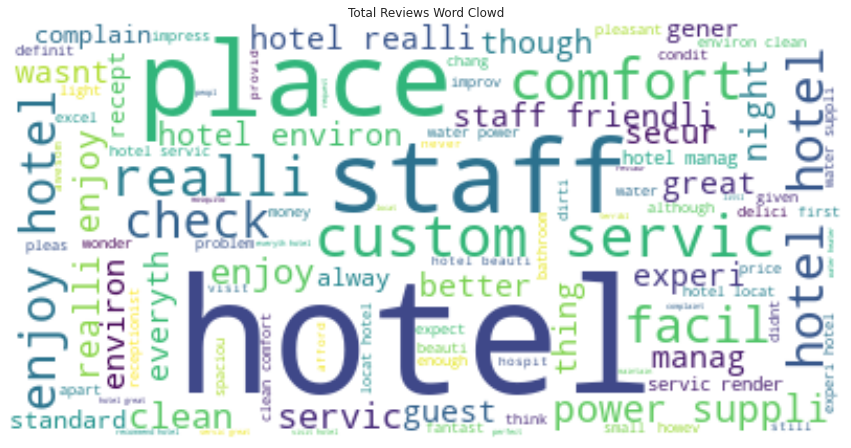

In [365]:
word_list = list(df.tokens.apply(pd.Series).stack())
text = ' '.join(word_list)

wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=100, min_word_length=5).generate(text)
 
# visualize the image
fig=plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Total Reviews Word Clowd')
plt.show()

**A visualization of some of the most popular words in the Reviews with Postive sentiment**

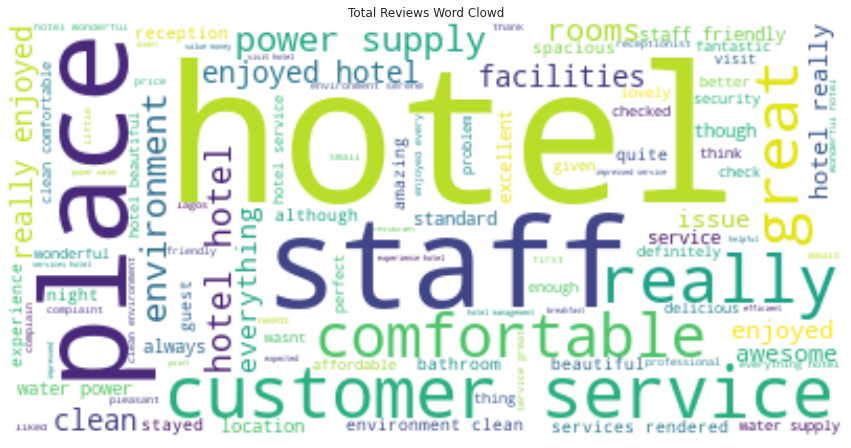

In [375]:
word_list_positive = list(df[df.target == 1].tokens.apply(pd.Series).stack())
text = ' '.join(word_list_positive)

wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=100, min_word_length=5).generate(text)
 
# visualize the image
fig=plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Total Reviews Word Clowd')
plt.show()

**A visualization of some of the most popular words in the Reviews with Negative sentiment**

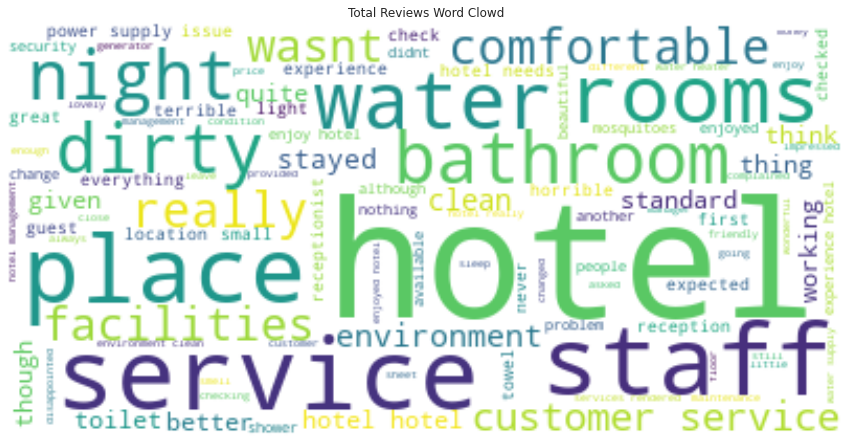

In [376]:
word_list_positive = list(df[df.target == 0].tokens.apply(pd.Series).stack())
text = ' '.join(word_list_positive)

wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=100, min_word_length=5).generate(text)
 
# visualize the image
fig=plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Total Reviews Word Clowd')
plt.show()

In [387]:
count_words = Counter(list(df.tokens.apply(pd.Series).stack()))
count_words.most_common(10)

[('hotel', 8714),
 ('stay', 4963),
 ('room', 3911),
 ('good', 2814),
 ('staff', 2188),
 ('nice', 2007),
 ('service', 1876),
 ('really', 1663),
 ('environment', 1503),
 ('well', 1498)]

We noticed from the above that words such as 'hotel', 'service', 'stay' and 'staff' are popular hence we can remove these words as well

In [ ]:
def clean_review(tokenized_review: str) -> List:
    """
    This function will remove Punctuatuon, Stopwords in a review

    Args
        tokenized_review: A tokenized review comment 

    Returns:
        List: A List containing the processed Review
    """

    # Remove any Punctuation
    stop_words = stopwords.words('english')
    stop_words += ['hotel', 'staff', 'service', 'stay']
    no_punc = [char for char in tokenized_review if char not in string.punctuation]
    no_punc = ''.join(no_punc)
    
    return [word for word in no_punc.split() if word.lower() not in stopwords.words('english')]


### 3. Normalization

**For this we would be Stemming words into thier stems**

In [284]:
def get_word_stem(tokenized_review: List) -> List:
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in tokenized_review]
    return stemmed

In [285]:
df.tokens = df.tokens.apply(get_word_stem)

**After Stemming**

In [226]:
df.tokens.head()

0               [enjoy, stay, felt, okay, staff, help]
1    [everyth, went, well, thought, stay, comfort, ...
2                    [comfort, environ, excel, servic]
3    [comfort, conveni, locat, breakfast, fantast, ...
4    [servic, bad, bed, good, checkingin, stress, c...
Name: reviews, dtype: object

### 3. Vectorize tokens for feature extraction

In [227]:
# Create a function that handles all our preprocessing

def preprocess_review(review_comment):
    cleaned_review = clean_review(review_comment)
    processed_review = get_word_stem(cleaned_review)
    return processed_review

In [228]:
vectorizer = CountVectorizer(
    analyzer = preprocess_review,
)

features = vectorizer.fit_transform(
    df.reviews
)

## Model Training

### Split Data into Train and Test Set

In [229]:
X_train, X_test, y_train, y_test  = train_test_split(
        features, 
        df.target,
        train_size=0.80, 
        random_state=32)

### Logistic Regression

In [230]:
log_model = LogisticRegression(solver='lbfgs', max_iter=400)
log_model = log_model.fit(X=X_train, y=y_train)

In [231]:
y_preds = log_model.predict(X_test)

In [232]:
print(classification_report(y_true=np.array(y_test), y_pred=y_preds))

              precision    recall  f1-score   support

           0       0.76      0.64      0.70       521
           1       0.82      0.89      0.85       967

    accuracy                           0.80      1488
   macro avg       0.79      0.77      0.78      1488
weighted avg       0.80      0.80      0.80      1488



Precision is defined as the number of true positives divided by the number of true positives plus the number of false positives. 

False positives are cases the model incorrectly labels as positive that are actually negative, . 

Recall expresses the ability to find all relevant instances in a dataset, precision expresses the proportion of the data points our model says was relevant actually were relevant.

(https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)

### Support Vector Classfier

In [240]:
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [241]:
y_preds = svm_model.predict(X_test)
print(classification_report(y_true=np.array(y_test), y_pred=y_preds))

              precision    recall  f1-score   support

           0       0.79      0.62      0.70       521
           1       0.82      0.91      0.86       967

    accuracy                           0.81      1488
   macro avg       0.80      0.77      0.78      1488
weighted avg       0.81      0.81      0.80      1488



<!-- 1. If n is large (1–10,000) and m is small (10–1000) : use logistic regression or SVM with a linear kernel.
2. If n is small (1–1000) and m is intermediate (10–10,000) : use SVM with (Gaussian, polynomial etc) kernel
3. If n is small (1–1000), m is large (50,000–1,000,000+): first, manually add more features and then use logistic regression or SVM with a linear kernel -->

## Hyperparameter Tuning

In [246]:
pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create parameter grid for Gridsearch

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.7min finished


In [250]:
print(classification_report(y_true=np.array(y_test), y_pred=best_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.64      0.70       521
           1       0.82      0.91      0.86       967

    accuracy                           0.81      1488
   macro avg       0.81      0.77      0.78      1488
weighted avg       0.81      0.81      0.81      1488



In [ ]:
We can see that we still end up with an accuracy of 81%, hence we will be 

## Random Predictions

In [347]:
def predict(clf, review_comment) -> str:
    transformed_ = vectorizer.transform(review_comment)
    sentiment = 'positive'  if clf.predict(transformed_) else 'negative'
    return sentiment

In [348]:
predict(clf, ["I had a terrible bad stay at the hotel"])

'negative'

In [349]:
predict(clf, ["The hotel was really great"])

'positive'

In [350]:
predict(clf, ['My stay was terrible, the room was mess, receptionist was rude I will never recommend the hotel for anyone.'])

'negative'

In [351]:
predict(clf, ['Really impressive staff'])

'positive'